By Prof. Seungchul Lee  
http://iai.postech.ac.kr/  
Industrial AI Lab at POSTECH  
(Translate to R by Gwangil Seo)

Table of Contents

   * [1. Data from our Testbed](#1.-Data-from-our-Testbed)
   * [2. Feature Extraction](#2.-Feature-Extraction)
      + [2.1. Feature Extraction from Time Domain](#2.1.-Feature-Extraction-from-Time-Domain)
      + [2.2. Feature Extraction from Frequency Domain](#2.2.-Feature-Extraction-from-Frequency-Domain)
   * [3. Fault Modes](#3.-Fault-Modes)
      + [3.1. Unbalance](#3.1.-Unbalance)
      + [3.2. Misalignment](#3.2.-Misalignment)
      + [3.3. Outer Race](#3.3.-Outer-Race)
      + [3.4. Inner Race](#3.4.-Inner-Race)
      
## 1. Data from Our Testbed

 * unbalance.mat $\Longrightarrow$ [01 02 03 04]
    + 01 : 시간
    + 02 : 불균형이 거의 없는 경우 진동(정상) 
    + 03 : 불균형이 있는 경우 진동 (1X성분이 증가) 3.6g * 44.4mm
    + 04 : 불균형이 더 심한 경우 진동 (1X성분이 매우 증가) 5.6g * 44.4mm


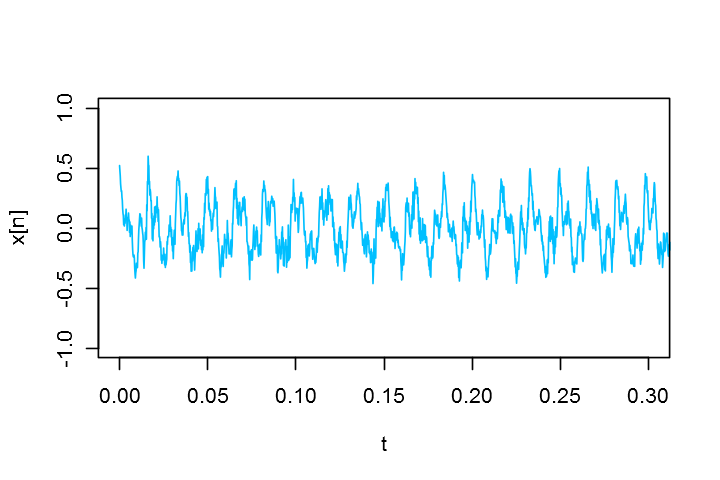

In [1]:
filename <- '../data_files/unbalance.mat'
data <- R.matlab::readMat(filename)$unbalance

time <- data[, 1]
x <- data[, 4]

options(repr.plot.width=6, repr.plot.height=4)
plot(time, x, type = 'l', col = 'deepskyblue', lwd = 1, xlim = c(0, 0.3), ylim = c(-1, 1),
     xlab = 't', ylab = 'x[n]')

## 2. Feature Extraction

### 2.1. Feature Extraction from Time Domain
__Moments of a signal: mean, variance, skewness, and kurtosis__

 * mean
 
 $$\bar x = {1 \over N}\sum_{n=1}^N x[n]$$
 
 * variance
 
 $$\text{var}(x) = {1 \over N - 1}\sum_{n=1}^N (x[n] - \bar x)^2 \\ \sigma = \sqrt{\text{var}}$$
 
 * Note: RMS (root mean square)
 
 $$\text{RMS} = \sqrt{{1 \over N} \sum_{n=1}^N x[n]^2} = \sqrt{\bar x^2 + \sigma ^2}$$

<center>
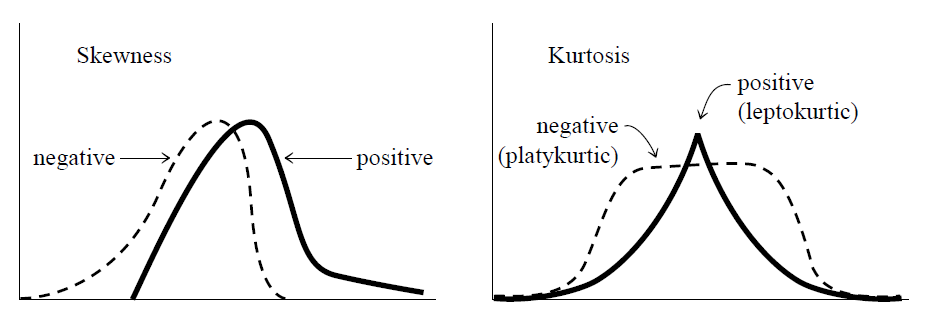
</center>

 * Skewness
   + a positive value of skewness signifies a distribution with an asymmetric tail extending out towards more positve $x$
   + a negative value signifies a distribution whose tail extends out towards more negative $x$
   
   $$ \text{skewness}(x) = {1 \over N}\sum_{n=1}^N \left( {x[n] - \bar x \over \sigma}\right) ^ 3$$
   
 * Kurtosis
   + It measures the relative peakedness or flatness of a distribution. Relative to what? A normal distribution
   
   $$\text{kurtosis}(x) = {1 \over N}\sum_{n=1}^N \left( {x[n] - \bar x \over \sigma}\right) ^ 4 - 3$$
   
$\qquad$ where the $-3$ term makes the value zero for a normal distribution

In [21]:
# mean
mean(x)

[1] 0.0002266506

In [22]:
# variance
var(x)

[1] 0.04031801

In [23]:
# rms
sqrt(mean(x ^ 2))

[1] 0.2007916

In [24]:
# skewness
moments::skewness(x)

[1] 0.169052

In [25]:
# kurtosis
moments::kurtosis(x)

[1] 2.375896

__Waveform related features__
 * Crest factor
 
 $$x_\text{max} \over x_\text{rms}$$
 
 * Impulse factor
 
 $$x_\text{max} \over x_\text{mean}$$
 
 * Shape factor
 
 $$x_\text{rms} \over x_\text{mean}$$

In [27]:
# crest factor
max(x) / sqrt(mean(x ^ 2))

[1] 3.022935

In [28]:
# impulse factor
max(x) / mean(x)

[1] 2678.043

In [29]:
# shape factor
sqrt(mean(x ^ 2)) / mean(x)

[1] 885.9082

### 2.2. Feature Extraction from Frequency Domain
 Amplitudes at the specific frequencies
 
  * Harmonics/subharmonics $(1X,\ 2X,\ 3X,\ ...)$
  * BPFI (ball pass frequency inner race)
  
  $$\text{BPFI} = {N \over 2} \times F \times \left( 1 + {B \over P}\text{cos}\theta\right)$$
  
  * BPFO (ball pass frequency outer race)
  
  $$\text{BPFO} = {N \over 2} \times F \times \left( 1 - {B \over P}\text{cos}\theta\right)$$
  
  * BSF (ball spin frequency)
  
  $$\text{BSF} = {P \over 2B} \times F \times \left[ 1 - \left( {B \over P}\text{cos}\theta \right) ^2 \right]$$
  
  * BDF (ball defect frequency)
  
  $$\text{BDF} = 2 \times \text{BSF} = {P \over B} \times F \times \left[ 1 - \left( {B \over P}\text{cos}\theta \right) ^2 \right]$$

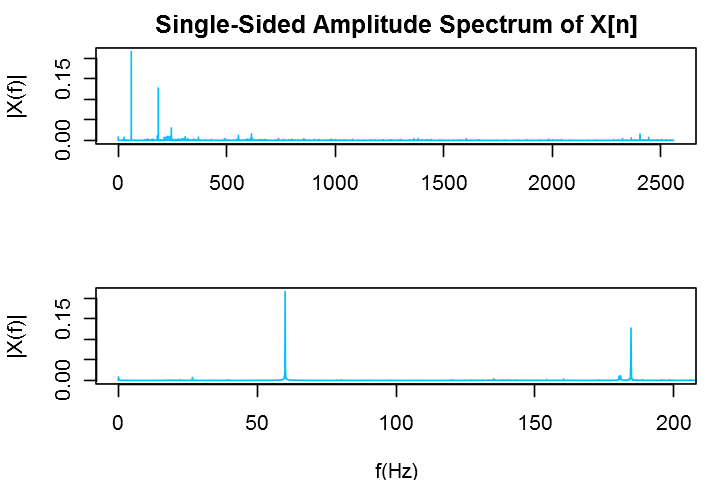

In [4]:
T <- time[2] - time[1]
Fs <- 1 / T

N <- length(time)
L <- N / Fs
t <- seq(0, tail(time, 1), T)

# single-sided fft
xt <- fft(x) / N
xtss <- xt[1:(N / 2 + 1)]
xtss[2:(length(xtss) - 1)] <- xtss[2:(length(xtss) - 1)] * 2

k <- 0:(N - 1)
f <- (Fs / N) * k
fss <- f[1:(N / 2 + 1)]

# plot
par(mfrow = c(2, 1), mar = c(4, 4, 2, 1))
plot(fss, abs(xtss), type = 'l', col = 'deepskyblue', lwd = 1,
     xlab = '', ylab = '|X(f)|', main = 'Single-Sided Amplitude Spectrum of X[n]')
plot(fss, abs(xtss), type = 'l', col = 'deepskyblue', lwd = 1,
     xlab = 'f(Hz)', ylab = '|X(f)|', main = '', xlim = c(0, 200))

$$X_\text{feature vector} = \text{amplitude at the specific frequency}$$

In [5]:
amplitude <- abs(xtss)

BPFO <- 183.183
c <- 20

filter01 <- rep(0, length(fss))
filter01[ceiling(N / Fs * (BPFO - c)):ceiling(N / Fs * (BPFO + c))] <- 1

(X1 <- max(amplitude * filter01))

[1] 0.1277773

## 3. Fault Modes

 * unbalance.mat $\Longrightarrow$ [01 02 03 04]
    + 01 : 시간
    + 02 : 불균형이 거의 없는 경우 진동(정상) 
    + 03 : 불균형이 있는 경우 진동 (1X성분이 증가) 3.6g * 44.4mm
    + 04 : 불균형이 더 심한 경우 진동 (1X성분이 매우 증가) 5.6g * 44.4mm

 * misalign.mat $\Longrightarrow$ [01 02 03]
    + 01 : 시간
    + 02 : 불균형이 있는 경우 진동 (1X성분이 증가) 3.6g * 44.4mm
    + 03 : 불균형이 있으면서, 정렬불량이 심한 경우 (2X 성분이 크게 증가) - 2mm 정렬불량

 * outerrace_fault.mat $\Longrightarrow$ [01 02 03 04]
    + 01 : 시간
    + 02 : 불균형이 있는 경우 진동 (1X성분이 증가) 3.6g * 44.4mm
    + 03 : 불균형이 있으면서, 외륜결함이 있는 경우
    + 04 : 불균형이 있으면서, 외륜결함으로 구동 중 베어링이 파손된 경우

 * innerrace_fault.mat $\Longrightarrow$ [01 02 03 04]
    + 01 : 시간
    + 02 : 불균형이 거의 없는 경우 진동(정상) 
    + 03 : 불균형이 있으면서, 내륜결함이 있는 경우
    + 04 : 불균형이 있으면서, 내륜결함으로 구동 중 베어링이 파손된 경우

### 3.1. Unbalance
 * unbalance.mat $\Longrightarrow$ [01 02 03 04]
    + 01 : 시간
    + 02 : 불균형이 거의 없는 경우 진동(정상) 
    + 03 : 불균형이 있는 경우 진동 (1X성분이 증가) 3.6g * 44.4mm
    + 04 : 불균형이 더 심한 경우 진동 (1X성분이 매우 증가) 5.6g * 44.4mm

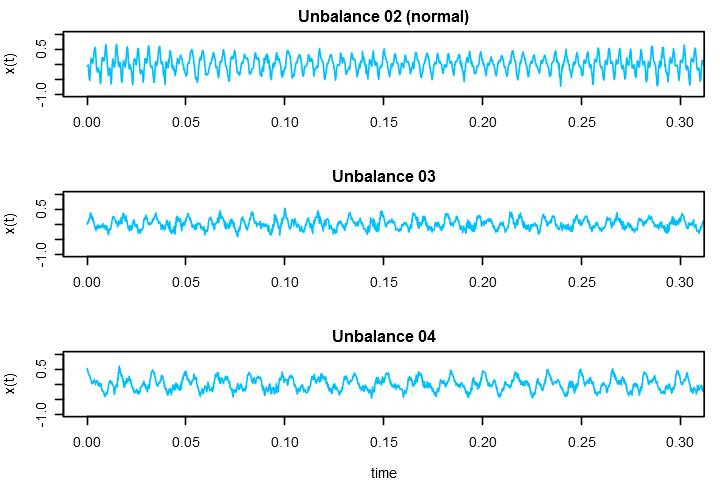

In [6]:
filename <- '../data_files/unbalance.mat'
data <- R.matlab::readMat(filename)$unbalance

time <- data[, 1]
unbal02 <- data[, 2]
unbal03 <- data[, 3]
unbal04 <- data[, 4]

par(mfrow = c(3, 1), mar = c(4, 4, 2, 1), oma = c(0, 0, 0, 0))
plot(time, unbal02, type = 'l', col = 'deepskyblue', lwd = 1, main = 'Unbalance 02 (normal)',
     xlab = '', ylab = 'x(t)', xlim = c(0, 0.3), ylim = c(-1, 1))
plot(time, unbal03, type = 'l', col = 'deepskyblue', lwd = 1, main = 'Unbalance 03',
     xlab = '', ylab = 'x(t)', xlim = c(0, 0.3), ylim = c(-1, 1))
plot(time, unbal04, type = 'l', col = 'deepskyblue', lwd = 1, main = 'Unbalance 04',
     xlab = 'time', ylab = 'x(t)', xlim = c(0, 0.3), ylim = c(-1, 1))

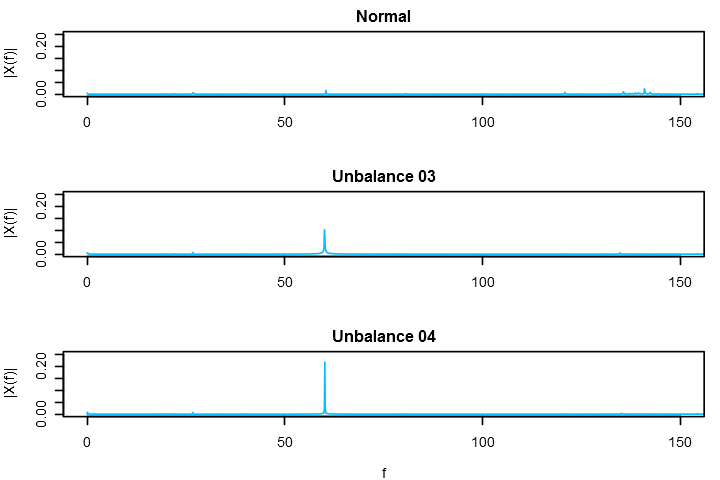

In [7]:
T <- time[2] - time[1]
Fs <- 1 / T
N <- length(time)
L <- N / Fs
t <- seq(0, tail(time , 1), T)

# single-sided fft
ut2 <- fft(unbal02) / N
ut2ss <- ut2[1:(N / 2 + 1)]
ut2ss[2:(length(ut2ss) - 1)] <- 2 * ut2ss[2:(length(ut2ss) - 1)]

ut3 <- fft(unbal03) / N
ut3ss <- ut3[1:(N / 2 + 1)]
ut3ss[2:(length(ut3ss) - 1)] <- 2 * ut3ss[2:(length(ut3ss) - 1)]

ut4 <- fft(unbal04) / N
ut4ss <- ut4[1:(N / 2 + 1)]
ut4ss[2:(length(ut4ss) - 1)] <- 2 * ut4ss[2:(length(ut4ss) - 1)]

k <- 0:(N - 1)
f <- (Fs / N) * k
fss <- f[1:(N / 2 + 1)]

# plot
par(mfrow = c(3, 1), mar = c(4, 4, 2, 1), oma = c(0, 0, 0, 0))
plot(fss, abs(ut2ss), type = 'l', col = 'deepskyblue', lwd = 1, main = 'Normal',
     xlab = '', ylab = '|X(f)|', xlim = c(0, 150), ylim = c(0, 0.25))
plot(fss, abs(ut3ss), type = 'l', col = 'deepskyblue', lwd = 1, main = 'Unbalance 03',
     xlab = '', ylab = '|X(f)|', xlim = c(0, 150), ylim = c(0, 0.25))
plot(fss, abs(ut4ss), type = 'l', col = 'deepskyblue', lwd = 1, main = 'Unbalance 04',
     xlab = 'f', ylab = '|X(f)|', xlim = c(0, 150), ylim = c(0, 0.25))

### 3.2. Misalignment

 * misalign.mat $\Longrightarrow$ [01 02 03]
    + 01 : 시간
    + 02 : 불균형이 있는 경우 진동 (1X성분이 증가) 3.6g * 44.4mm
    + 03 : 불균형이 있으면서, 정렬불량이 심한 경우 (2X 성분이 크게 증가) - 2mm 정렬불량

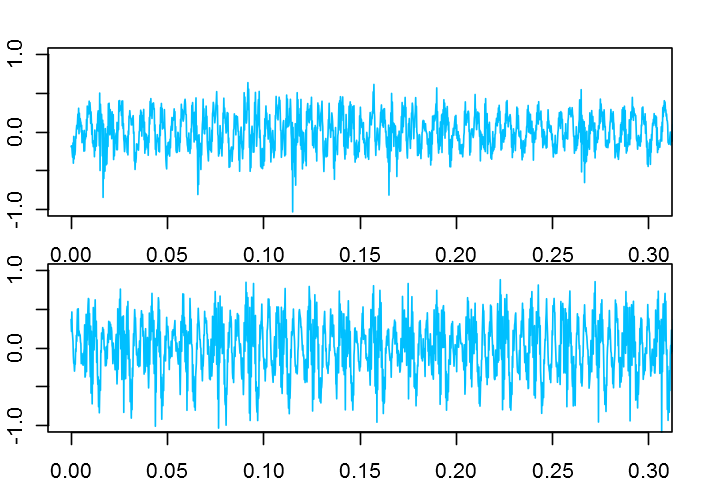

In [8]:
filename <- '../data_files/misalign.mat'
data <- R.matlab::readMat(filename)$misalign

time <- data[, 1]
misalign02 <- data[, 2]
misalign03 <- data[, 3]

par(mfrow = c(2, 1), mar = c(1, 1, 1, 1), oma = c(1, 1, 1, 1))
plot(time, misalign02, type = 'l', col = 'deepskyblue', lwd = 1,
     xlim = c(0, 0.3), ylim = c(-1, 1), xlab = '', ylab = '', main = '')
plot(time, misalign03, type = 'l', col = 'deepskyblue', lwd = 1,
     xlim = c(0, 0.3), ylim = c(-1, 1), xlab = '', ylab = '', main = '')

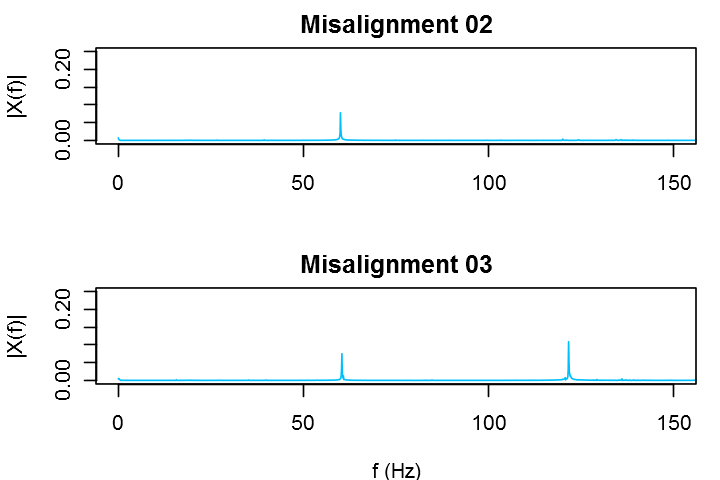

In [9]:
T <- time[2] - time[1]
Fs <- 1 / T
N <- length(time)
L <- N / Fs
t <- seq(0, tail(time, 1), T)

# single-sided fft
mt2 <- fft(misalign02) / N
mt2ss <- mt2[1:(N / 2 + 1)]
mt2ss[2:(length(mt2ss) - 1)] <- 2 * mt2ss[2:(length(mt2ss) - 1)]

mt3 <- fft(misalign03) / N
mt3ss <- mt3[1:(N / 2 + 1)]
mt3ss[2:(length(mt3ss) - 1)] <- 2 * mt3ss[2:(length(mt3ss) - 1)]

k <- 0:(N - 1)
f <- (Fs / N) * k
fss <- f[1:(N / 2 + 1)]

# plot
par(mfrow = c(2, 1), mar = c(4, 4, 2, 1), oma = c(0, 0, 0, 0))
plot(fss, abs(mt2ss), type = 'l', col = 'deepskyblue', lwd = 1, main = 'Misalignment 02',
     xlab = '', ylab = '|X(f)|', xlim = c(0, 150), ylim = c(0, 0.25))
plot(fss, abs(mt3ss), type = 'l', col = 'deepskyblue', lwd = 1, main = 'Misalignment 03',
     xlab = 'f (Hz)', ylab = '|X(f)|', xlim = c(0, 150), ylim = c(0, 0.25))

### 3.3. Outer Race

 * outerrace_fault.mat $\Longrightarrow$ [01 02 03 04]
    + 01 : 시간
    + 02 : 불균형이 있는 경우 진동 (1X성분이 증가) 3.6g * 44.4mm
    + 03 : 불균형이 있으면서, 외륜결함이 있는 경우
    + 04 : 불균형이 있으면서, 외륜결함으로 구동 중 베어링이 파손된 경우

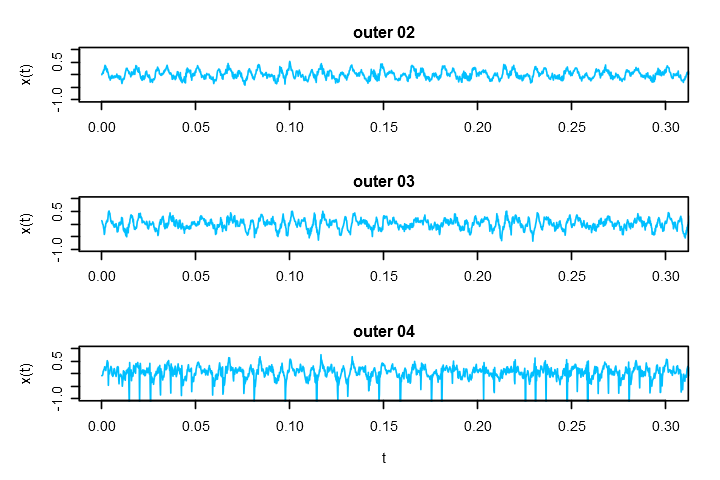

In [10]:
filename <- '../data_files/outerrace_fault.mat'
data <- R.matlab::readMat(filename)$outer

time <- data[, 1]
out02 <- data[, 2]
out03 <- data[, 3]
out04 <- data[, 4]

par(mfrow = c(3, 1), mar = c(4, 4, 2, 1), oma = c(1, 1, 1, 1))
plot(time, out02, type = 'l', col = 'deepskyblue', xlim = c(0, 0.3), ylim = c(-1, 1),
     xlab = '', ylab = 'x(t)', main = 'outer 02')
plot(time, out03, type = 'l', col = 'deepskyblue', xlim = c(0, 0.3), ylim = c(-1, 1),
     xlab = '', ylab = 'x(t)', main = 'outer 03')
plot(time, out04, type = 'l', col = 'deepskyblue', xlim = c(0, 0.3), ylim = c(-1, 1),
     xlab = 't', ylab = 'x(t)', main = 'outer 04')

In [11]:
T <- time[2] - time[1]
Fs <- 1 / T
N <- length(time)
L <- N / Fs
t <- seq(0, tail(time, 1), T)

ot2 <- fft(out02) / N
ot2ss <- ot2[1:(N / 2 + 1)]
ot2ss[2:(length(ot2ss) - 1)] <- 2 * ot2ss[2:(length(ot2ss) - 1)]

ot3 <- fft(out03) / N
ot3ss <- ot3[1:(N / 2 + 1)]
ot3ss[2:(length(ot3ss) - 1)] <- 2 * ot3ss[2:(length(ot3ss) - 1)]

ot4 <- fft(out04) / N
ot4ss <- ot4[1:(N / 2 + 1)]
ot4ss[2:(length(ot4ss) - 1)] <- 2 * ot4ss[2:(length(ot4ss) - 1)]

k <- 0:(N - 1)
f <- (Fs / N) * k
fss <- f[1:(N / 2 + 1)]

In [12]:
BSF <- 119.621
BPFO <- 183.183
BDF <- 239.242
BPFI <- 296.817

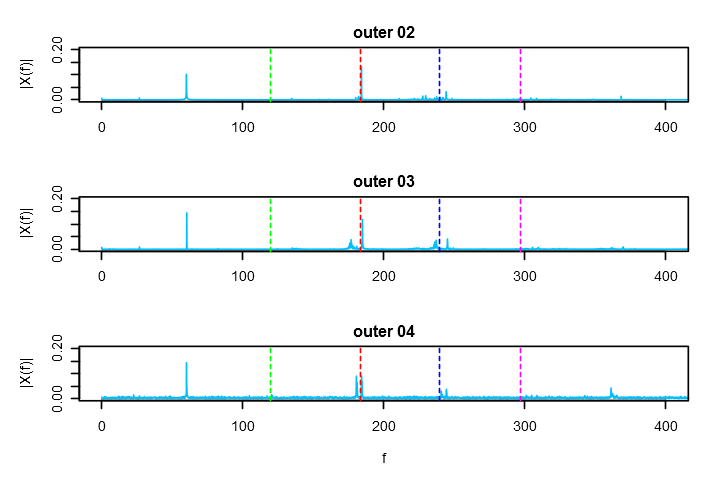

In [13]:
par(mfrow = c(3, 1), mar = c(4, 4, 2, 1), oma = c(1, 1, 1, 1))
plot(fss, abs(ot2ss), type = 'l', col = 'deepskyblue', xlim = c(0, 400), ylim = c(0, 0.2),
     main = 'outer 02', xlab = '', ylab = '|X(f)|')
abline(v = c(BSF, BPFO, BDF, BPFI), lty = 2, col = c('green', 'red', 'blue', 'magenta'))
plot(fss, abs(ot3ss), type = 'l', col = 'deepskyblue', xlim = c(0, 400), ylim = c(0, 0.2),
     main = 'outer 03', xlab = '', ylab = '|X(f)|')
abline(v = c(BSF, BPFO, BDF, BPFI), lty = 2, col = c('green', 'red', 'blue', 'magenta'))
plot(fss, abs(ot4ss), type = 'l', col = 'deepskyblue', xlim = c(0, 400), ylim = c(0, 0.2),
     main = 'outer 04', xlab = 'f', ylab = '|X(f)|')
abline(v = c(BSF, BPFO, BDF, BPFI), lty = 2, col = c('green', 'red', 'blue', 'magenta'))

In [14]:
# smoothing using moving average (MA) model

windowsize <- 5
b <- rep(1, windowsize) / windowsize
a <- 1

out02ma <- signal::filter(b, a, out02)  # ARMA filter AR ~ a, MA ~ b
out02mar <- out02 - out02ma  # use residual

out03ma <- signal::filter(b, a, out03)
out03mar <- out03 - out03ma

out04ma <- signal::filter(b, a, out04)
out04mar <- out04 - out04ma

In [15]:
# envelope analysis

out02mare <- abs(hht::HilbertTransform(out02mar))
out03mare <- abs(hht::HilbertTransform(out03mar))
out04mare <- abs(hht::HilbertTransform(out04mar))

out02marez <- out02mare - mean(out02mare)  # remove DC offset
out03marez <- out03mare - mean(out03mare)
out04marez <- out04mare - mean(out04mare)

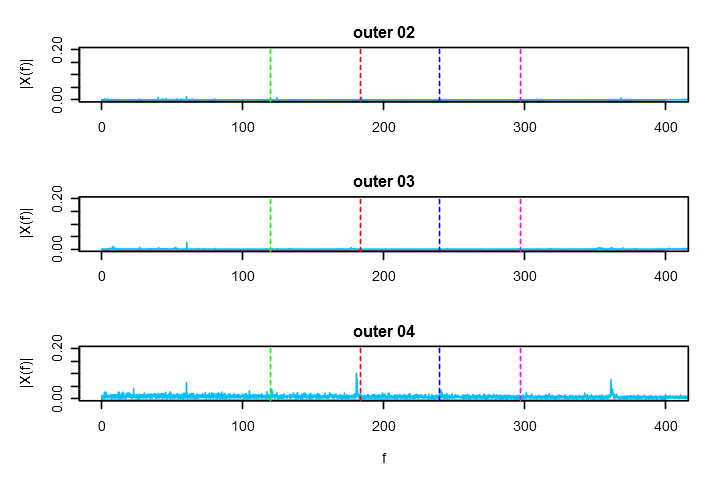

In [16]:
T <- time[2] - time[1]
Fs <- 1 / T
N <- length(time)
L <- N / Fs
t <- seq(0, tail(time, 1), T)

# single-sided fft
oet2 <- fft(out02marez) / N
oet2ss <- oet2[1:(N / 2 + 1)]
oet2ss[2:(length(oet2ss) - 1)] <- 2 * oet2ss[2:(length(oet2ss) - 1)]

oet3 <- fft(out03marez) / N
oet3ss <- oet3[1:(N / 2 + 1)]
oet3ss[2:(length(oet3ss) - 1)] <- 2 * oet3ss[2:(length(oet3ss) - 1)]

oet4 <- fft(out04marez) / N
oet4ss <- oet4[1:(N / 2 + 1)]
oet4ss[2:(length(oet4ss) - 1)] <- 2 * oet4ss[2:(length(oet4ss) - 1)]

k <- 0:(N - 1)
f <- (Fs / N) * k
fss <- f[1:(N / 2 + 1)]

par(mfrow = c(3, 1), mar = c(4, 4, 2, 1), oma = c(1, 1, 1, 1))
plot(fss, abs(oet2ss), type = 'l', col = 'deepskyblue', xlim = c(0, 400), ylim = c(0, 0.2),
     main = 'outer 02', xlab = '', ylab = '|X(f)|')
abline(v = c(BSF, BPFO, BDF, BPFI), lty = 2, col = c('green', 'red', 'blue', 'magenta'))
plot(fss, abs(oet3ss), type = 'l', col = 'deepskyblue', xlim = c(0, 400), ylim = c(0, 0.2),
     main = 'outer 03', xlab = '', ylab = '|X(f)|')
abline(v = c(BSF, BPFO, BDF, BPFI), lty = 2, col = c('green', 'red', 'blue', 'magenta'))
plot(fss, abs(oet4ss), type = 'l', col = 'deepskyblue', xlim = c(0, 400), ylim = c(0, 0.2),
     main = 'outer 04', xlab = 'f', ylab = '|X(f)|')
abline(v = c(BSF, BPFO, BDF, BPFI), lty = 2, col = c('green', 'red', 'blue', 'magenta'))

### 3.4. Inner Race

 * innerrace_fault.mat $\Longrightarrow$ [01 02 03 04]
    + 01 : 시간
    + 02 : 불균형이 거의 없는 경우 진동(정상) 
    + 03 : 불균형이 있으면서, 내륜결함이 있는 경우
    + 04 : 불균형이 있으면서, 내륜결함으로 구동 중 베어링이 파손된 경우

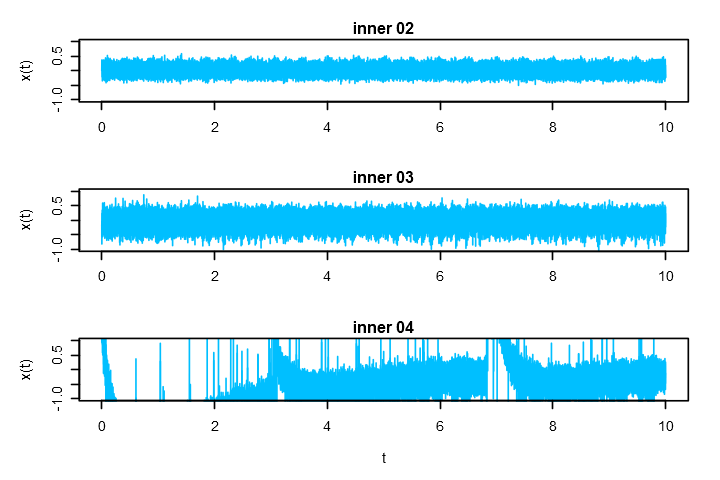

In [17]:
filename <- '../data_files/innerrace_fault.mat'
data <- R.matlab::readMat(filename)$inner

time <- data[, 1]
in02 <- data[, 2]
in03 <- data[, 3]
in04 <- data[, 4]

par(mfrow = c(3, 1), mar = c(4, 4, 1.5, 1), oma = c(1, 1, 1, 1))
plot(time, in02, type = 'l', col = 'deepskyblue', xlim = c(0, 10), ylim = c(-1, 1),
     xlab = '', ylab = 'x(t)', main = 'inner 02')
plot(time, in03, type = 'l', col = 'deepskyblue', xlim = c(0, 10), ylim = c(-1, 1),
     xlab = '', ylab = 'x(t)', main = 'inner 03')
plot(time, in04, type = 'l', col = 'deepskyblue', xlim = c(0, 10), ylim = c(-1, 1),
     xlab = 't', ylab = 'x(t)', main = 'inner 04')

In [18]:
# smoothing using moving average (MA) model

windowsize <- 5
b <- rep(1, windowsize) / windowsize
a <- 1

in02ma <- signal::filter(b, a, in02)  # ARMA filter AR ~ a, MA ~ b
in02mar <- in02 - in02ma  # use residual

in03ma <- signal::filter(b, a, in03)
in03mar <- in03 - in03ma

in04ma <- signal::filter(b, a, in04)
in04mar <- in04 - in04ma

In [19]:
# envelope analysis

in02mare <- abs(hht::HilbertTransform(in02mar))
in03mare <- abs(hht::HilbertTransform(in03mar))
in04mare <- abs(hht::HilbertTransform(in04mar))

in02marez <- in02mare - mean(in02mare)  # remove DC offset
in03marez <- in03mare - mean(in03mare)
in04marez <- in04mare - mean(in04mare)

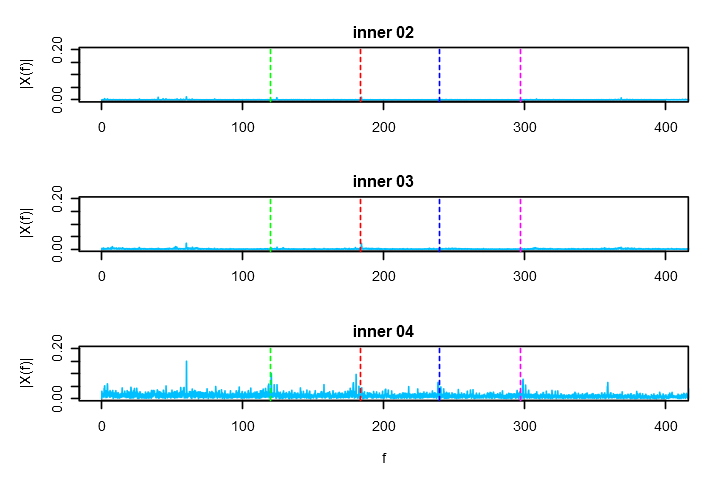

In [20]:
T <- time[2] - time[1]
Fs <- 1 / T
N <- length(time)
L <- N / Fs
t <- seq(0, tail(time, 1), T)

# single-sided fft
iet2 <- fft(in02marez) / N
iet2ss <- iet2[1:(N / 2 + 1)]
iet2ss[2:(length(iet2ss) - 1)] <- 2 * iet2ss[2:(length(iet2ss) - 1)]

iet3 <- fft(in03marez) / N
iet3ss <- iet3[1:(N / 2 + 1)]
iet3ss[2:(length(iet3ss) - 1)] <- 2 * iet3ss[2:(length(iet3ss) - 1)]

iet4 <- fft(in04marez) / N
iet4ss <- iet4[1:(N / 2 + 1)]
iet4ss[2:(length(iet4ss) - 1)] <- 2 * iet4ss[2:(length(iet4ss) - 1)]

k <- 0:(N - 1)
f <- (Fs / N) * k
fss <- f[1:(N / 2 + 1)]

par(mfrow = c(3, 1), mar = c(4, 4, 2, 1), oma = c(1, 1, 1, 1))
plot(fss, abs(iet2ss), type = 'l', col = 'deepskyblue', xlim = c(0, 400), ylim = c(0, 0.2),
     main = 'inner 02', xlab = '', ylab = '|X(f)|')
abline(v = c(BSF, BPFO, BDF, BPFI), lty = 2, col = c('green', 'red', 'blue', 'magenta'))
plot(fss, abs(iet3ss), type = 'l', col = 'deepskyblue', xlim = c(0, 400), ylim = c(0, 0.2),
     main = 'inner 03', xlab = '', ylab = '|X(f)|')
abline(v = c(BSF, BPFO, BDF, BPFI), lty = 2, col = c('green', 'red', 'blue', 'magenta'))
plot(fss, abs(iet4ss), type = 'l', col = 'deepskyblue', xlim = c(0, 400), ylim = c(0, 0.2),
     main = 'inner 04', xlab = 'f', ylab = '|X(f)|')
abline(v = c(BSF, BPFO, BDF, BPFI), lty = 2, col = c('green', 'red', 'blue', 'magenta'))